In [1]:
import numpy as np
import fluxion.comp_graph as cg
import fluxion.data_loader as dl
import fluxion.optimize as opt
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [2]:
# if ./datasets directory does not exist, create it
if not os.path.exists("./datasets"):
    os.makedirs("./datasets")

# download MNIST dataset train and test
mnist_trn = dl.MNISTLoader("./datasets/MNIST", batch_size=512, split='train')
mnist_trn.load_into_memory()
mnist_trn.normalize()

mnist_tst = dl.MNISTLoader("./datasets/MNIST", batch_size=512, split='test')
mnist_tst.load_into_memory()
mnist_tst.normalize()

# randomly shuffle the datasets
mnist_trn.shuffle()
mnist_tst.shuffle()

In [3]:
X_plt, Y_plt = mnist_trn.get_next_batch()

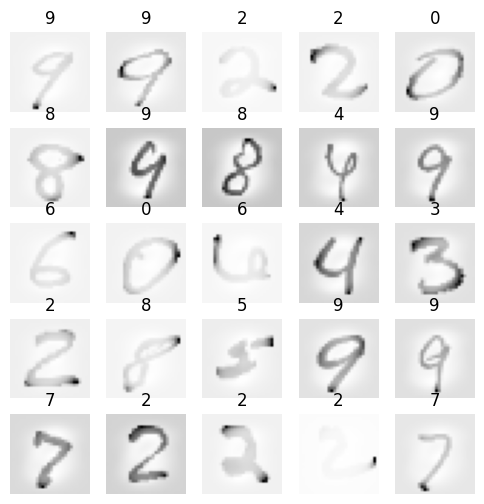

In [4]:
fig, axes = plt.subplots(5, 5, figsize=(6, 6))
axes = axes.flatten()
i = 0
for x, y in zip(X_plt[:25], Y_plt[:25]):
    ax = axes[i]
    ax.imshow(x, cmap='Grays')
    ax.set_axis_off()
    ax.set_title(y)
    i += 1
plt.show()

In [5]:
# define our NN

d_in = 28*28
d_hid = 50
n_classes = 10

lr = 1e-1

w_A_np = np.random.normal(size=(d_in, d_hid))
w_C_np = np.random.normal(size=(d_hid, n_classes))

w_A = cg.Value(
    "w_A", 
    w_A_np, 
    optimizer=opt.SGD(name='sgd', lr=lr, values=w_A_np, beta=0.9), 
    optimize=True
) # params in linear layer
linear1 = cg.Dot("linear1")

act1 = cg.ReLU("act1")

w_C = cg.Value(
    "w_C", 
    w_C_np,
    optimizer=opt.SGD(name='sgd', lr=lr, values=w_C_np, beta=0.9), 
    optimize=True
) # params in a linear layer
linear2 = cg.Dot("linear2")

loss = cg.CrossEntropyLoss("crossent", n_classes=n_classes)

In [6]:
def NN_predict(X):
    # calls to forward pass to define the function topology
    X.forward()
    w_A.forward()
    w_C.forward()
    y = linear1.forward(X, w_A)
    y = act1.forward(linear1)
    y = linear2.forward(act1, w_C)
    return y

def NN_forward(X, Y):
    _ = NN_predict(X)
    l = loss.forward(linear2, Y)
    return l

In [7]:
epochs = 100
losses = []
prog_bar = tqdm(range(epochs))
n_batch = mnist_trn.n_batch
for epoch in prog_bar:
    # at beginning of each epoch, randomly shuffle
    mnist_trn.shuffle()
    for batch in range(n_batch):
        X_lst, Y_lst = mnist_trn.get_next_batch()
        X_np = np.array([x.flatten() for x in X_lst])
        Y_np = np.array(Y_lst)
        X = cg.Value("X", X_np) # input vector

        # call forward pass
        l = NN_forward(X, Y_np)

        losses.append(l.item())

        # call backward pass on topo sorted graph
        fn_graph = cg.Graph("NN", [loss])
        fn_graph.backward()

        # step the optimizer to update weights
        fn_graph.step_optimizer()

    prog_bar.set_description(f"loss: {np.mean(losses[-n_batch:])}")

loss: 0.013638859187457948: 100%|██████████| 100/100 [00:34<00:00,  2.94it/s]


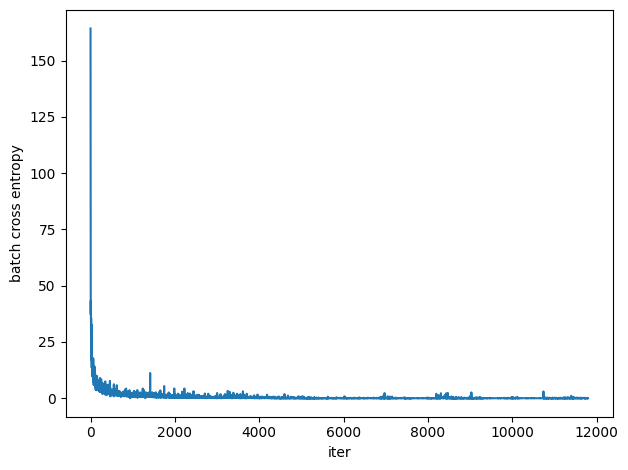

In [8]:
plt.plot(losses)
plt.xlabel("iter")
plt.ylabel("batch cross entropy")
plt.tight_layout()
plt.show()

In [9]:
# calculate the test accuracy
n_batch = mnist_tst.n_batch
n_correct = 0
n_data    = 0
for batch in range(n_batch):
    X_lst, Y_lst = mnist_tst.get_next_batch()
    X_np = np.array([x.flatten() for x in X_lst])
    Y_np = np.array(Y_lst)
    X = cg.Value("X", X_np) # input vector
    Y_pred = NN_predict(X)
    Y_pred = np.argmax(Y_pred, axis=-1)
    n_correct += np.sum(Y_pred == Y_np)
    n_data += len(Y_np)
print(f"test accuracy: {n_correct/n_data:.3f}")

test accuracy: 0.959
